# Sounds classification

In this notebook we will consider urban sounds classification using CNNs.

The notebook is based on this [notebook](https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw2/HW2.ipynb).

# Installation

Firstly, we need to install several python libraries we will use in this notebook.

Yes, I made it myself)) Took a long time to train

In [15]:
!pip install torchtext==0.8.1 torch==1.7.1 pytorch-lightning==1.2.2 torchaudio==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.7.1-cp39-cp39-manylinux1_x86_64.whl (776.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.8.0
    Uninstalling torchaudio-0.8.0:
      Successfully uninstalled torchaudio-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.7.1 which is incompatible.
lightning 2.0.0rc1 requires torch<4.0,>=1.11.0, but you have torch 1.7.1 which is incompatible.


In [16]:
import pytorch_lightning as pl

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython import display
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset


device = "cuda:0"

/usr/local/lib/python3.9/dist-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# Data

In this notebook we will classify audio files from [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset.

It contains 8732 records of various urban sounds, that are splitted on train/val/test subsamples.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

In [18]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [19]:
# download the data
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown "https://drive.google.com/uc?id=1XY-jjMs_CQ9ZSD0lMecUSIYKkRI0BG2s&confirm=t" && unzip -qq HW2_dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1XY-jjMs_CQ9ZSD0lMecUSIYKkRI0BG2s&confirm=t
To: /content/data/HW2_dataset.zip
100% 1.57G/1.57G [00:06<00:00, 246MB/s]


# Pytorch dataset

The dataset contains the following 10 defferent classes.

In [20]:
# sound classes
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
           'siren', 'street_music']

Define the following class for the dataset. It will read audio records from files and resturn objects `(x, y, len)`, where `x` is a waveform data of a record, `y` is a class label and `len` is length of the record. All waveforms will have the same size of `pad_size`. If a record is shorter than `pad_size`, it will be filled with zeros.

In [7]:
SAMPLE_RATE = 44100

In [26]:
import os
import pandas as pd
import numpy as np


class AudioDataset(Dataset):
    def __init__(self, path_to_csv, 
                 path_to_folder, 
                 pad_size=384000,
                 sr=SAMPLE_RATE):
        
        self.csv = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size
        self.sr = sr
        
        self.class_to_idx = {classes[i]: i for i in range(10)}

    
    def __getitem__(self, index):
        
        item = self.csv.iloc[index]
        wav_idx, cl = item

        path = os.path.join(self.path_to_folder, f'{wav_idx}.wav')
        wav, sr = torchaudio.load(path)
        wav = wav[0]
        len = wav.shape[0]

        wav_padded = torch.zeros(self.pad_size)
        wav_padded[:len] = wav

        instance = {
            'x': wav_padded,
            'y': self.class_to_idx[cl],
            'len': len
        }

        return instance

    
    def __len__(self):
        return self.csv.shape[0]

Create train and validation datasets

In [27]:
train_dataset = AudioDataset('./data/urbansound8k/train_part.csv', './data/urbansound8k/data')
val_dataset = AudioDataset('./data/urbansound8k/val_part.csv', './data/urbansound8k/data')

# Example

In [28]:
# get the first record
item = train_dataset.__getitem__(0)

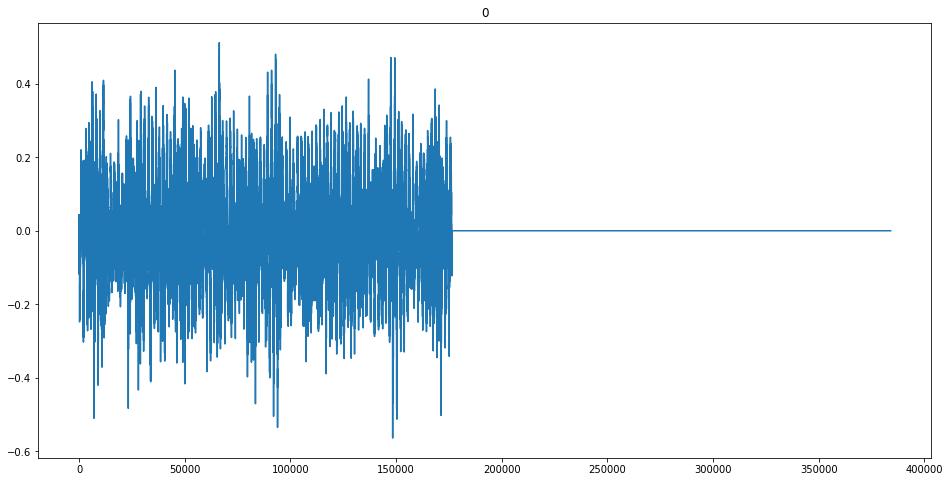

In [29]:
# plot the waveform
plt.figure(figsize=(16, 8))
plt.plot(item['x'])
plt.title(item['y'])

# play the record
display.Audio(item['x'], rate=SAMPLE_RATE)

# Dataloaders

Create dataloaders, that we will used to fit our neural network.

In [30]:
train_dataloader = DataLoader(train_dataset, 32, shuffle=True, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32, pin_memory=True)

# Mel spectrogram

We will use mel spectrograms of the records as inputs for our model. Let's define a function, that transforms waveforms into log mel spectrograms.

In [34]:
from torchaudio.transforms import MelSpectrogram

def compute_log_melspectrogram(wav_batch, lens, device='cpu'):
    
    featurizer = MelSpectrogram(
                            sample_rate=SAMPLE_RATE,
                            n_fft=1024,
                            win_length=1024,
                            hop_length=256,
                            n_mels=64
                            ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

In [35]:
# get a batch of records
for batch in train_dataloader:
    break

wav_batch = batch['x']
y_batch = batch['y']
lens = batch['len']

In [51]:
# get log of mel spectrograms
log_melspect, lens = compute_log_melspectrogram(wav_batch, lens)

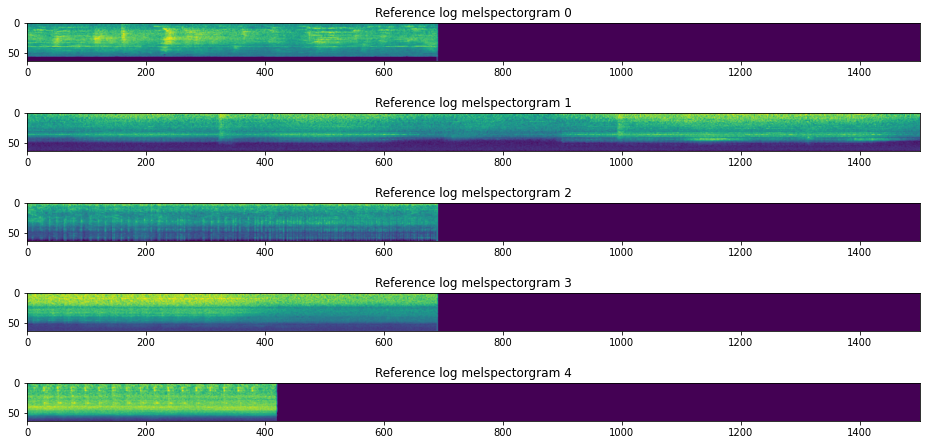

In [37]:
# plot the result
plt.figure(figsize=(16, 8))

for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.imshow(log_melspect[i].numpy())
    plt.title(f'Reference log melspectorgram {i}')

# Classification

# Task 1

Implement the convolutional neural network CNN10 from the paper [PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition](https://arxiv.org/pdf/1912.10211.pdf):

* 2x (Conv2d 3x3 @ 16, BN, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BN, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BN, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BN, ReLU)
* (Conv2d 2x2 @ 128, BN, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

**Hint:** use functions `nn.Conv2d()`, `nn.BatchNorm2d()` and `nn.ReLU()`. For mel spectrograms use `compute_log_melspectrogram` function.

In [52]:
import torch
from torch.nn import functional as F
from torch import nn

class Model(pl.LightningModule):

    def __init__(self, num_classes=10, hidden=16):
        super().__init__()
        
        
        self.cnn = nn.Sequential(
            
            ### BEGIN SOLUTION (Ok, zoomer)
            nn.Conv2d(1, 16, 3),
            nn.Conv2d(16, 16, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3),
            nn.Conv2d(32, 32, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU()
            ### END SOLUTION 
        )

        
        self.mlp = nn.Sequential(
            nn.Linear(8 * hidden, 8 * hidden), 
            nn.ReLU(),
            nn.Linear(8 * hidden, num_classes)
        )

    
    def forward(self, x):
        z = self.cnn(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        z = self.mlp(z)
        return z

    
    # calculate loss function values
    def training_step(self, batch, batch_idx):
        x = batch['x']
        y = batch['y']
        lens = batch['len']

        # get log mel spectrograms
        ### BEGIN SOLUTION

        log_melspect, lens = compute_log_melspectrogram(x, lens)
        ### BEGIN SOLUTION
        
        pred = self(log_melspect)
        
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(pred, y)
        return loss

    
    # define optimizer to fit the network
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

# Fit model

Fit the model. It takes about 15 minutes.

In [53]:
%%time

# define trainer to fit out network
trainer = pl.Trainer(max_epochs=10, gpus=0)

# init our netwrok
model = Model()

# fit the netwrok
trainer.fit(model, train_dataloader)

GPU available: False, used: False
INFO:lightning:GPU available: False, used: False
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores

  | Name | Type       | Params
------------------------------------
0 | cnn  | Sequential | 212 K 
1 | mlp  | Sequential | 17.8 K
------------------------------------
229 K     Trainable params
0         Non-trainable params
229 K     Total params
0.919     Total estimated model params size (MB)
INFO:lightning:
  | Name | Type       | Params
------------------------------------
0 | cnn  | Sequential | 212 K 
1 | mlp  | Sequential | 17.8 K
------------------------------------
229 K     Trainable params
0         Non-trainable params
229 K     Total params
0.919     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

CPU times: user 2h 25min 45s, sys: 1h 9min 7s, total: 3h 34min 53s
Wall time: 3h 39min 15s


1

# Validation

If you solve the task correctly, you will get accuracy on validation about `0.92`.

In [54]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_dataloader, device):
    
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        with torch.no_grad():
            x, lens = compute_log_melspectrogram(x, lens, device=device)
            probs = model(x)
            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f'Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}')

    cm_df = pd.DataFrame(
        confusion_matrix([p[1] for p in pred_true_pairs], 
                         [p[0] for p in pred_true_pairs], 
                         normalize='true'),
        columns=classes, index=classes)
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.9219251336898395


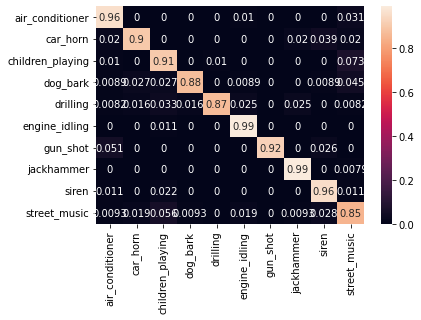

In [55]:
plot_confusion_matrix(model, val_dataloader, model.device)

This took 3 hours in running... Is it worth it? No. Should you give me a 100? Probably)
Song of the day is "Потерянный Рай" - Ария